# Calculating spontaneous and noise correlations

In [71]:
import pool
import flow
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cascade as cas
from copy import deepcopy
import os
import pandas as pd

In [13]:
driven=True
drive_css=('0', '135', '270')
drive_threshold=15

In [ ]:
mice = ['OA27', 'OA26', 'OA67', 'VF226', 'CC175']
cses = ['plus', 'minus', 'neutral', '0', '135', '270']
tags = None

for m in mice:
    days = flow.DateSorter.frommeta(mice=[m], tags=tags)
    for d in days:
        for cs in cses:
            pool.calc.correlations.noise(d, cs, trange=(0, 3), cutoff_before_lick_ms=50)
            pool.calc.correlations.noise(d, cs, trange=(0, 3))


In [62]:
np.shape(test[d1_ids_bool][:, d1_ids_bool])

(217, 217)

<Figure size 432x288 with 0 Axes>

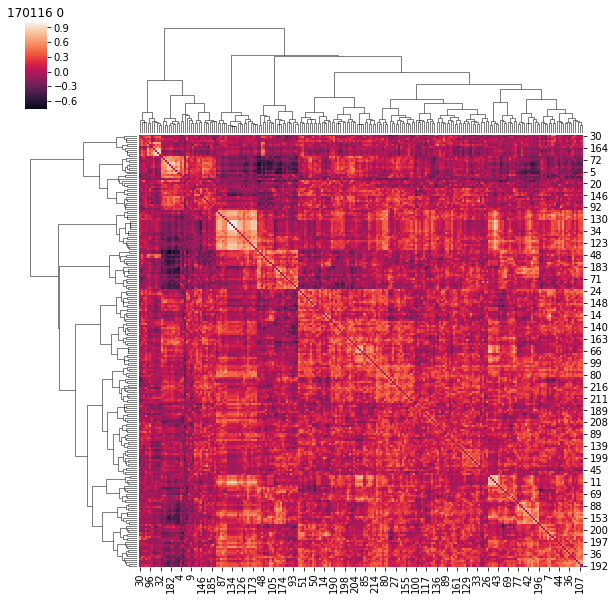

<Figure size 432x288 with 0 Axes>

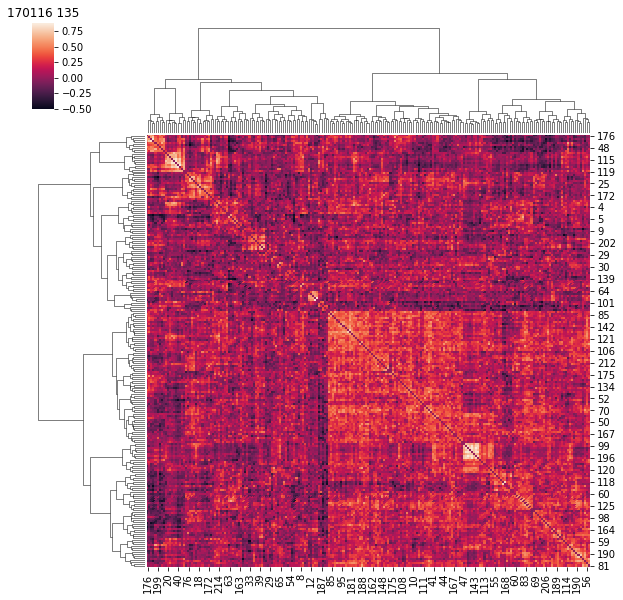

<Figure size 432x288 with 0 Axes>

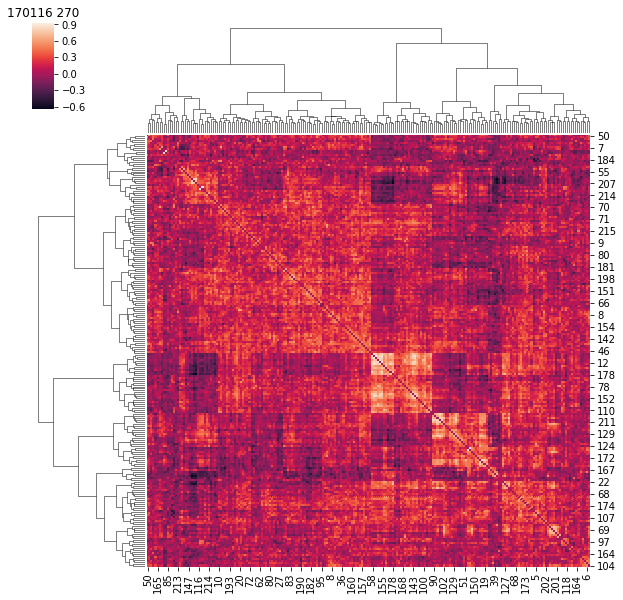

In [15]:
days = flow.DateSorter.frommeta(mice=['OA27'], tags=None)
for c, day1 in enumerate(days):
    
    # get cell_ids
    d1_ids = flow.xday._read_crossday_ids(day1.mouse, day1.date)
    d1_ids = np.array([int(s) for s in d1_ids])

    # filter cells based on visual/trial drive across all cs, prevent
    # breaking when only pavs are shown
    if driven:
        good_ids = cas.tca._group_drive_ids(days, drive_css, drive_threshold)
        d1_ids_bool = np.isin(d1_ids, good_ids)
        d1_sorter = np.argsort(d1_ids[d1_ids_bool])
    else:
        d1_ids_bool = np.ones(np.shape(d1_ids)) > 0
        d1_sorter = np.argsort(d1_ids[d1_ids_bool])
    ids = d1_ids[d1_ids_bool][d1_sorter]
    
    for cs in ['0', '135', '270']:
        test = pool.calc.correlations.noise(day1, cs)
        if np.sum(np.isnan(test.flatten())) > 0:
            continue
        plt.figure()
        sns.clustermap(test[d1_ids_bool][:, d1_ids_bool], method='ward')
        plt.title(str(days[c].date) + ' ' + cs)
    break

In [ ]:
np.shape(test)
plt.figure()
sns.clustermap(test)

In [153]:
# singleday_factors_annotated(
mouse='OA27'
trace_type='zscore_day'
method='ncp_bcd'
cs=''
warp=False
word='convinced'
extra_col=4
alpha=0.6
plot_running=True
filetype='pdf'
scale_y=False
verbose=False

pars = {'trace_type': trace_type, 'cs': cs, 'warp': warp}

days = flow.DateSorter.frommeta(mice=[mouse], tags=None)

cell_sz = np.shape(cas.df.get_xdaymap(mouse))

cell_map = np.zeros(cell_sz)
cell_map[:] = np.nan
cell_map_w = deepcopy(cell_map)
nz_daily = []
clus_daily = []
acorr_daily = []
for d, day1 in enumerate(days):
    
#     # all cells
#     d1_ids = flow.xday._read_crossday_ids(day1.mouse, day1.date)
    
#     # all runs
#     d1_runs = day1.runs()
    
#     # get all trace2p
#     for run in d1_runs:
#         t2p = run.trace2p()
        
    # load dir
    load_dir = cas.paths.tca_path(mouse, 'single',
                              pars=pars, word=word)
    tensor_path = os.path.join(load_dir, str(day1.mouse)
                               + '_' + str(day1.date)
                               + '_single_decomp_'
                               + str(trace_type) + '.npy')
    input_tensor_path = os.path.join(load_dir, str(day1.mouse)
                                     + '_' + str(day1.date)
                                     + '_single_tensor_'
                                     + str(trace_type) + '.npy')
    input_ids_path = os.path.join(load_dir, str(day1.mouse)
                                  + '_' + str(day1.date)
                                  + '_single_ids_'
                                  + str(trace_type) + '.npy')
    meta_path = os.path.join(load_dir, str(day1.mouse)
                             + '_' + str(day1.date)
                             + '_df_single_meta.pkl')

    # load your data
    ensemble = np.load(tensor_path)
    ensemble = ensemble.item()
    ids = np.load(input_ids_path)
    intensor = np.load(input_tensor_path)
    
    # for plus only
    meta = pd.read_pickle(meta_path)
    orientation = meta['orientation']
    bool270 = np.isin(orientation, 270)
    
#     intensor = intensor[:,:,bool270]
    
#     print(np.shape(intensor))
#     intensor_mean = np.mean(intensor, axis=2)
#     mean_sub_intensor = np.zeros(np.shape(intensor))
#     test = np.zeros((np.shape(intensor)[0], np.shape(intensor)[2]))
#     tri_list = []
#     tri_list2 = []
#     for tri in range(np.shape(intensor)[2]):
# #         mean_sub_intensor[:,:,tri] = intensor[:,:,tri] - intensor_mean
#         tri_list.append(intensor[:,:,tri] - intensor_mean)
#         tri_list2.extend(np.mean(intensor[:,16:(16*3),tri], axis=1) - np.mean(intensor_mean[:,16:(16*3)], axis=1))
#         test[:,tri] = np.mean(intensor[:,16:(16*3),tri], axis=1) - np.mean(intensor_mean[:,16:(16*3)], axis=1)
# #     print(np.shape(test))
#     long_way = np.concatenate(tri_list, axis=1)
# #     plt.figure()
# #     plt.imshow(np.corrcoef(long_way), aspect='auto')
# #     plt.colorbar()
# #     plt.figure()
# #     plt.imshow(np.corrcoef(test), aspect='auto')
# #     plt.colorbar()
#     test_mcorr = np.corrcoef(test)
#     test_lcorr =np.corrcoef(np.corrcoef(long_way))
    
    # remaking same randomization as arthurs calc
    randomizations=500
    trange=(-1, 6)
    cscorr = {}
    for cs in ['0', '135', '270']:
#         trs = pool.stimulus.trials(day1, cs, start_s=trange[0], end_s=trange[1], trace_type='dff',
#                               cutoff_before_lick_ms=-1, error_trials=-1)
        
        trs = np.nanmean(intensor[:,16:48,:], axis=1)
        ncells = np.shape(trs)[0]
        corrs = np.zeros((ncells, ncells))
        corrs[:, :] = np.nan

        # Catch cases when there aren't enough trials
        if np.shape(trs)[1] < 10:
            continue

        stimorder = np.arange(np.shape(trs)[1])
        if np.sum(np.invert(np.isfinite(trs))) == 0:
            corrs = np.corrcoef(trs)

            for i in range(randomizations):
                for c in range(ncells):
                    np.random.shuffle(stimorder)
                    trs[c, :] = trs[c, stimorder]

                corrs -= np.corrcoef(trs)/float(randomizations)
        cscorr[cs] = corrs    
    acorr_daily.append(cscorr)
    
    # all ids for the day
    d1_ids = flow.xday._read_crossday_ids(day1.mouse, day1.date)
    d1_ids = np.array([int(s) for s in d1_ids])

    # get all noise correlations
    nz = {}
    for cs in ['0', '135', '270']:
        nz_corr = pool.calc.correlations.noise(day1, cs, trange=(0, 3), cutoff_before_lick_ms=50)
        nz_bool = np.isin(d1_ids, ids)
        nz_corr_sub = nz_corr[nz_bool, :][:, nz_bool]
        nz[cs] = nz_corr_sub

    # sort neuron factors by component they belong to most
    sort_ensemble, my_sorts = cas.tca._sortfactors(ensemble[method])

    cell_ids = {}  # keys are rank
    cell_clusters = {}
    nz_corr_rank = {}
    itr_num = 0  # use only best iteration of TCA, index 0
    for k in sort_ensemble.results.keys():
        # factors are already sorted, so these will define
        # clusters, no need to sort again
        factors = sort_ensemble.results[k][itr_num].factors[0]
        max_fac = np.argmax(factors, axis=1)
        cell_clusters[k] = max_fac
        if k == 10:
            clus_daily.append(cell_clusters[k])
        cell_ids[k] = ids[my_sorts[k-1]]
#         if k == 10:
#             print(cell_ids[k])
        new_nz = deepcopy(nz)
        for cs in ['0', '135', '270']:
            new_nz[cs] = new_nz[cs][my_sorts[k-1], :][:, my_sorts[k-1]]
#             if (k == 10) & (cs == '270'):
#                 plt.figure()
#                 sns.heatmap(nz[cs])
#                 plt.title(str(cs))
#                 plt.figure()
#                 sns.heatmap(new_nz[cs])
#                 plt.title(str(cs + ' sorted'))
        nz_corr_rank[k] = new_nz
    nz_daily.append(nz_corr_rank)


    cell_weights = {}
    for k in sort_ensemble.results.keys():
        factors = sort_ensemble.results[k][itr_num].factors[0]
        best_fac = np.zeros(np.shape(factors[:,0]))
        for c in range(np.shape(factors)[1]):
            fac_vec = deepcopy(factors[:, c])
            fac_vec[cell_clusters[k] != c] = 0
            best_fac += fac_vec
        cell_weights[k] = best_fac
    
    match_rank = 10
    for cell in range(len(cell_clusters[match_rank])): # cell ids are 1 indexed
        if cell_weights[match_rank][cell] < 0.3:
            continue
        cell_idx = cell_ids[match_rank][cell]
        cell_map[cell_idx, d] = cell_clusters[match_rank][cell]
        cell_map_w[cell_idx, d] = cell_weights[match_rank][cell]
    

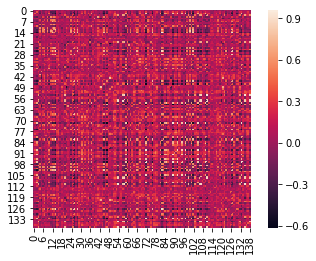

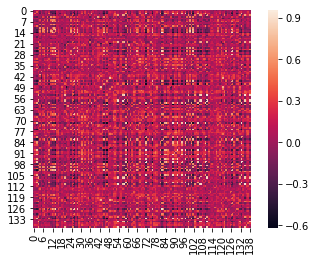

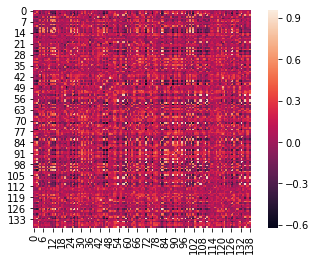

In [155]:
plt.figure()
sns.heatmap(acorr_daily[0]['0'], square=True)
plt.figure()
sns.heatmap(acorr_daily[0]['135'], square=True)
plt.figure()
sns.heatmap(acorr_daily[0]['270'], square=True)

In [150]:
stimorder = np.arange(np.shape(trs)[1])
print(stimorder)
np.random.shuffle(stimorder)
print(stimorder)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134]
[ 30  29  69  72  51  48  24 111  49  76  87   1 113  13  11  39  22 109
  44  89  77 114 122  74  25  73 121  79  50  18   2 105  86  90 132   4
  32 118  61  28  91  63  46  43  42   3  55  84  15  33  65 125  82 129
   9  14 120  67   5 119  99 112   0  98  31  37 133  97  47 102  95  10
  83  52 106 124  68  81  80  58   7  75  57  88  93  20  56 104 128  40
  17  60 123  12  85  96 107  53  62 101  16  19  36  35 110  26  41 134
   6  70  94 

<Figure size 432x288 with 0 Axes>

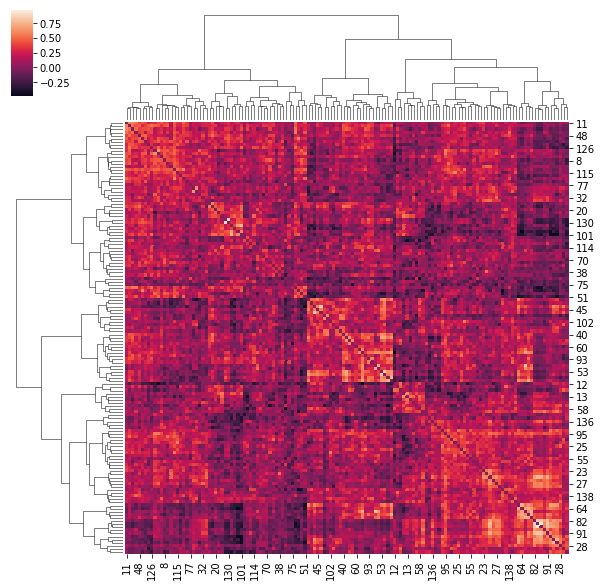

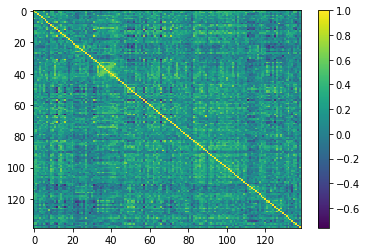

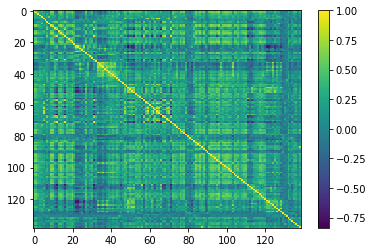

In [84]:
plt.figure()
from_calc = pool.calc.correlations.noise(day1, '270', 
                                         trange=(0, 2),
                                         cutoff_before_lick_ms=50,
                                         trace_type='dff')[np.isin(d1_ids, ids),:][:,np.isin(d1_ids, ids)]
# plt.imshow(from_calc[my_sorts[9],:][:,my_sorts[9]], aspect='auto')
sns.clustermap(from_calc[my_sorts[9],:][:,my_sorts[9]], method='ward')
# plt.colorbar()

plt.figure()
plt.imshow(test_mcorr[my_sorts[9],:][:,my_sorts[9]], aspect='auto')
plt.colorbar()

plt.figure()
plt.imshow(test_lcorr[my_sorts[9],:][:,my_sorts[9]], aspect='auto')
plt.colorbar()

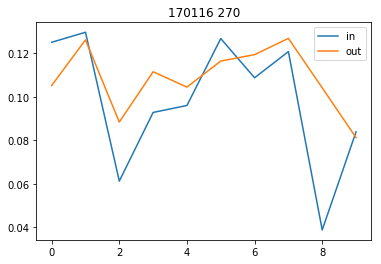

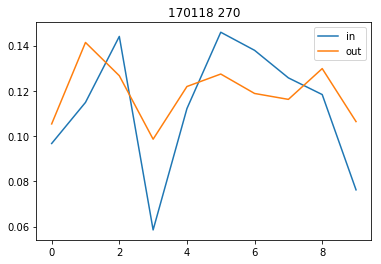

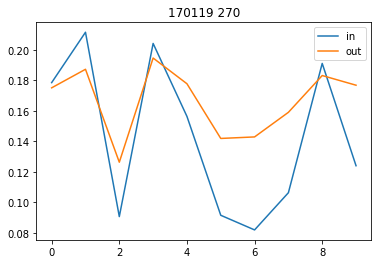

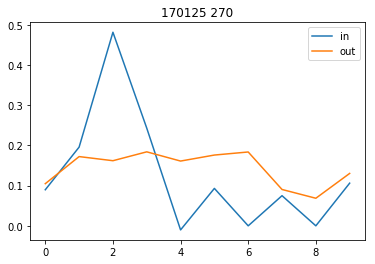

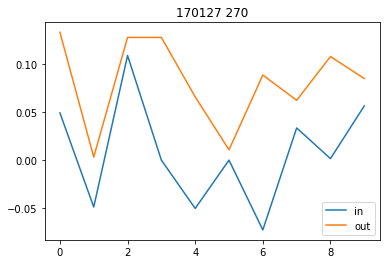

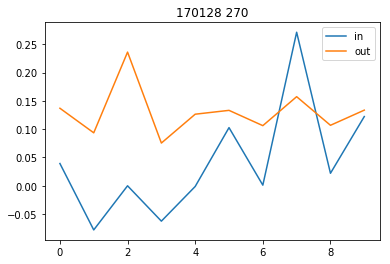

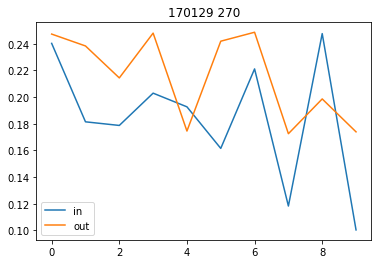

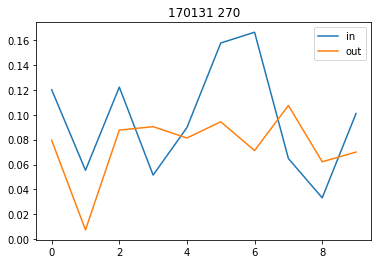

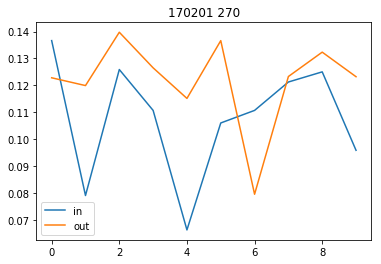

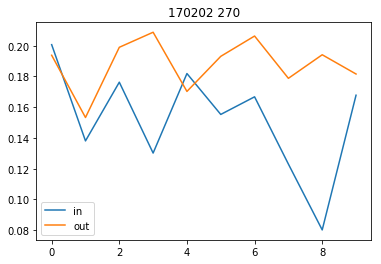

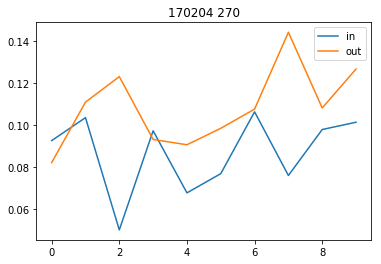

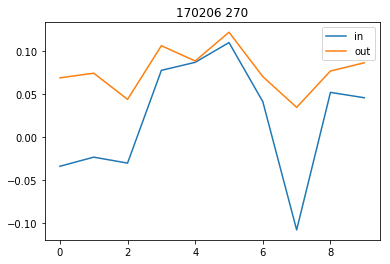

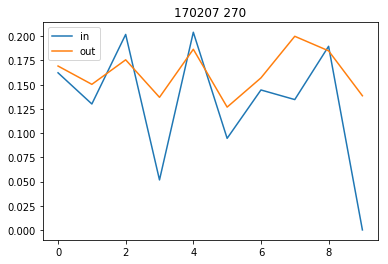

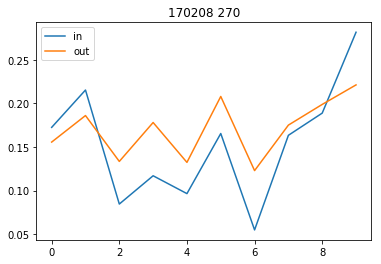

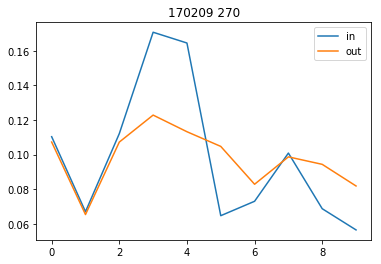

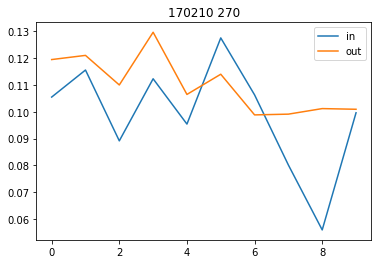

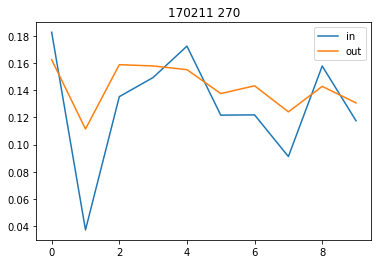

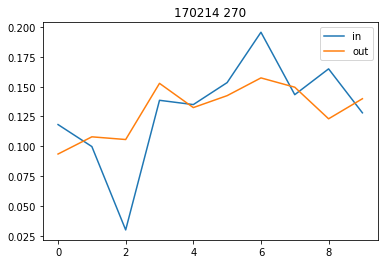

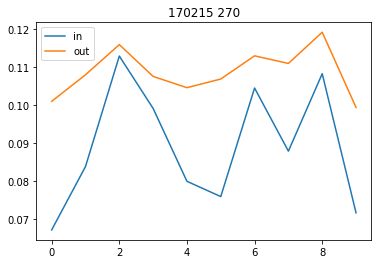

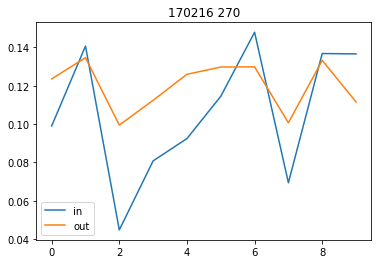

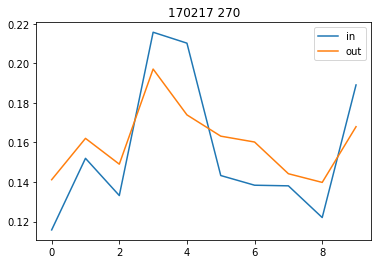

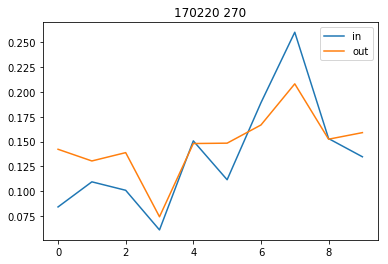

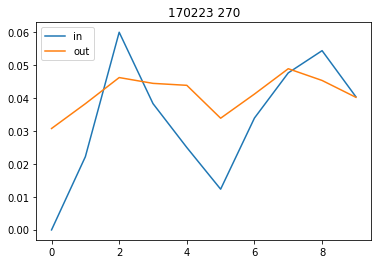

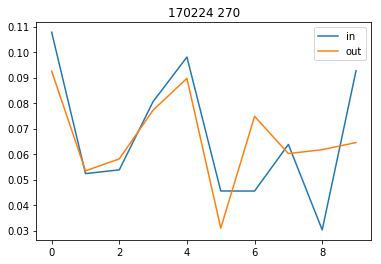

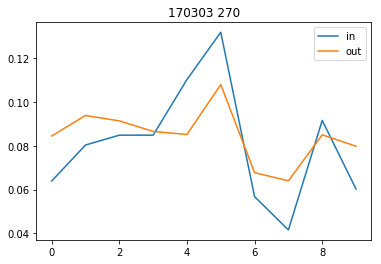

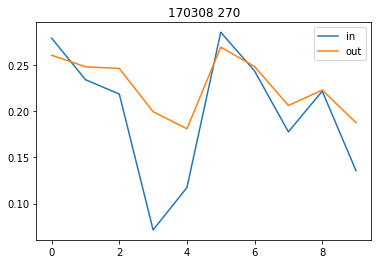

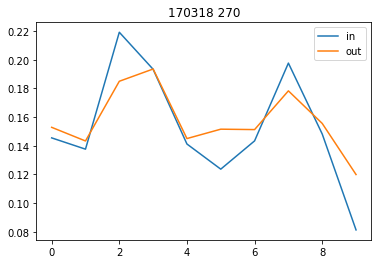

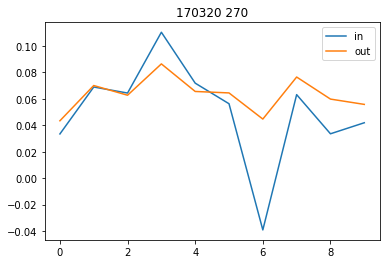

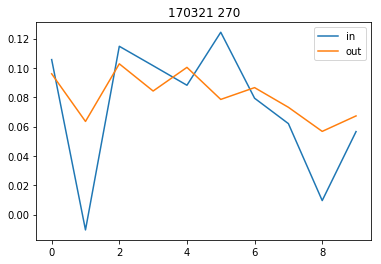

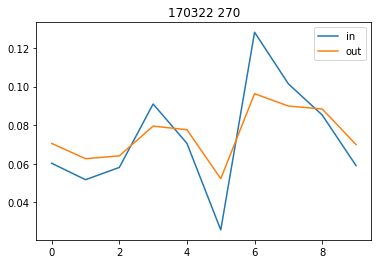

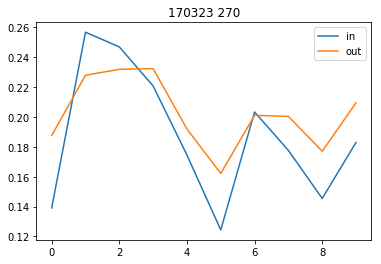

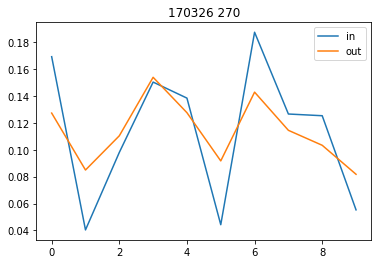

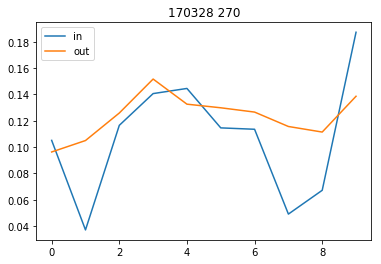

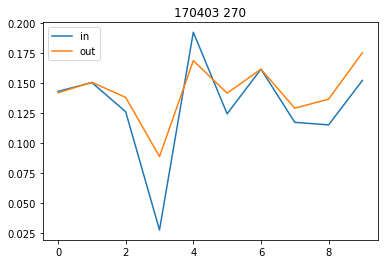

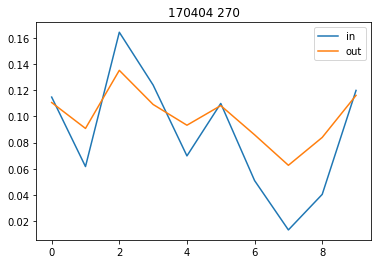

In [133]:
# looking at mean within vs across group corr by factor
cmap = sns.color_palette('muted', match_rank)
cs = '270'
r = 10
for c, res in enumerate(nz_daily):
#     print(res[10])
    if np.sum(np.isnan(res[r][cs]).flatten()) > 0:
        continue
    color_vec = [cmap[int(k)] for k in clus_daily[c]]
    
    ingroup = np.zeros(r)
    outgroup = np.zeros(r)
    allgroup = np.zeros((r,r))
    for r1 in np.unique(clus_daily[c]):
        for r2 in np.unique(clus_daily[c]):
            bool_fac1 = clus_daily[c] == r1
            bool_fac2 = clus_daily[c] == r2
            allgroup[r1, r2] = np.mean(res[r][cs][:, bool_fac1][bool_fac2, :])
        ingroup[r1] = np.mean(res[r][cs][:, bool_fac1][bool_fac1, :])
        outgroup[r1] = np.mean(res[r][cs][:, bool_fac1][~bool_fac1, :])
        
    plt.figure()
#     plt.imshow(allgroup)

    plt.plot(ingroup, label='in')
    plt.plot(outgroup, label = 'out')
    plt.legend()
#     plt.colorbar()
#     sns.clustermap(res[r][cs], row_cluster=True, col_cluster=True, method='ward', row_colors=color_vec, col_colors=color_vec)
    plt.title(str(days[c].date) + ' ' + cs)

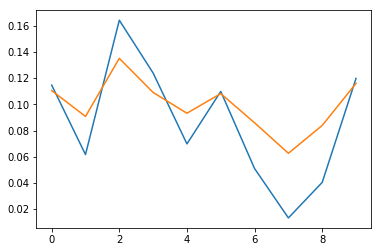

In [132]:
plt.figure()
plt.plot(ingroup)
plt.plot(outgroup)

In [127]:
bool_fac2

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

<Figure size 432x288 with 0 Axes>

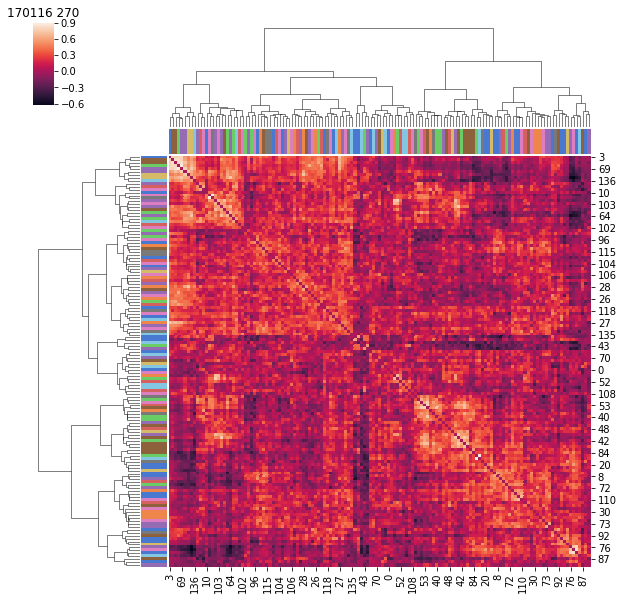

<Figure size 432x288 with 0 Axes>

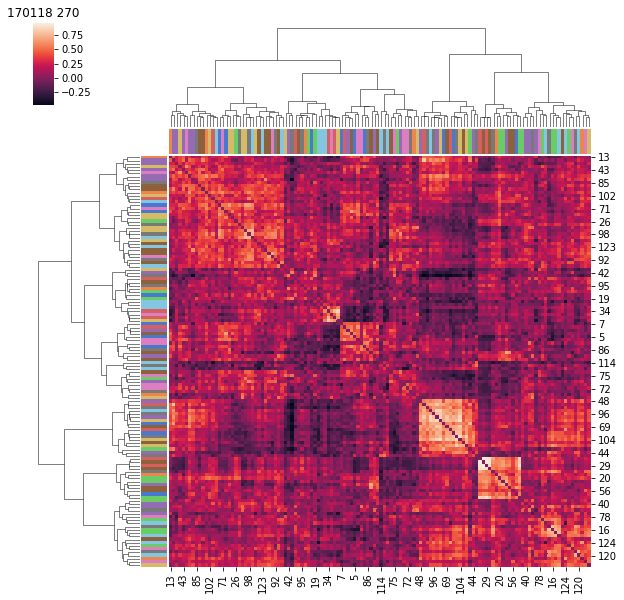

<Figure size 432x288 with 0 Axes>

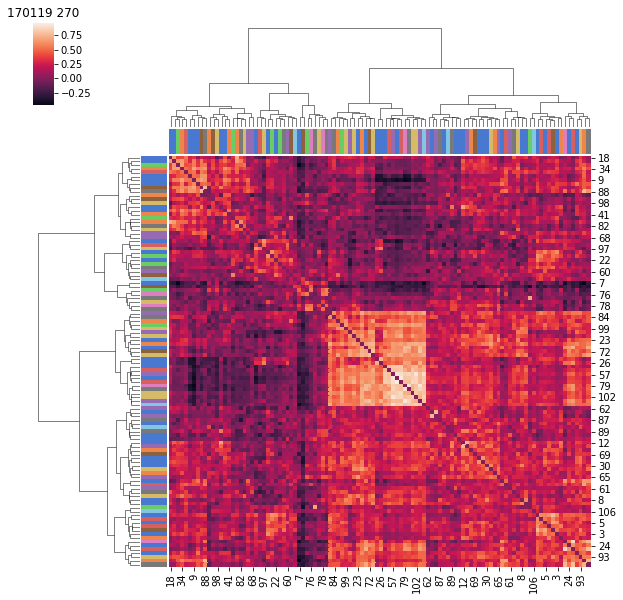

<Figure size 432x288 with 0 Axes>

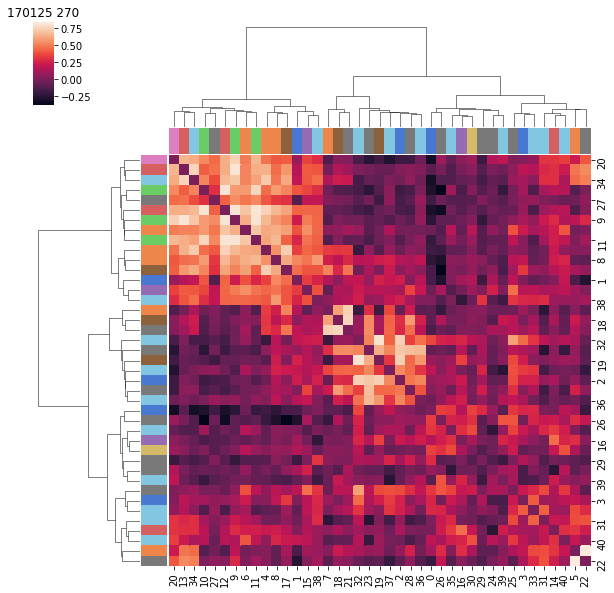

<Figure size 432x288 with 0 Axes>

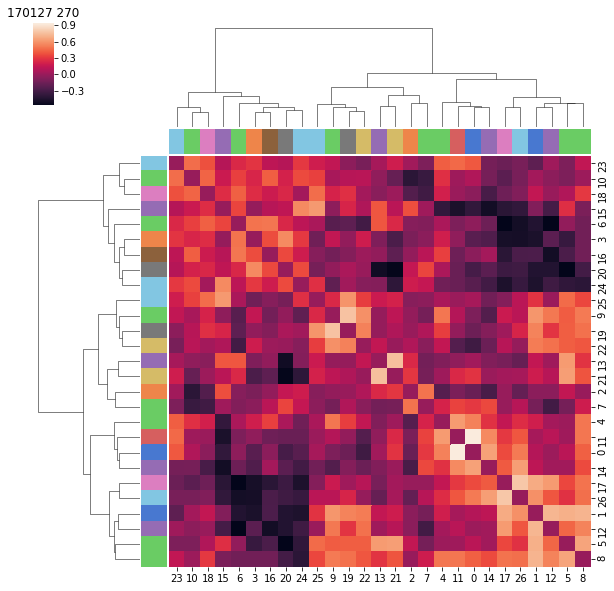

<Figure size 432x288 with 0 Axes>

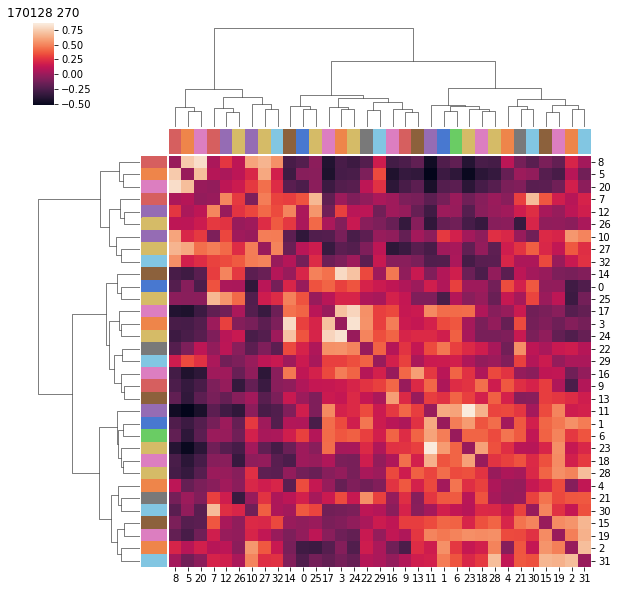

<Figure size 432x288 with 0 Axes>

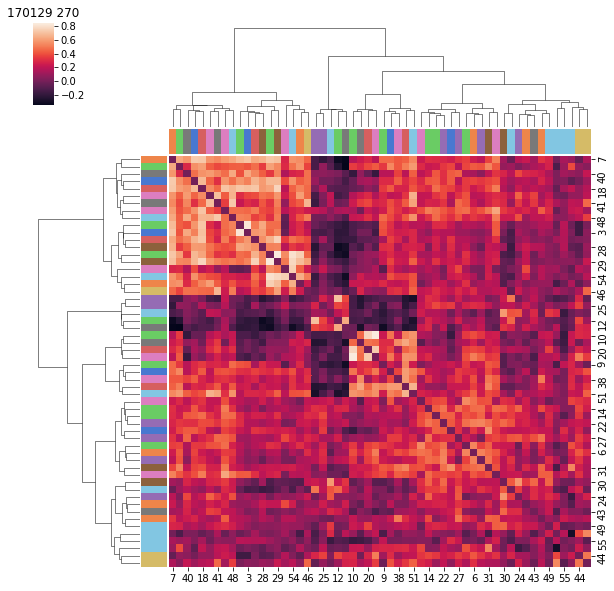

<Figure size 432x288 with 0 Axes>

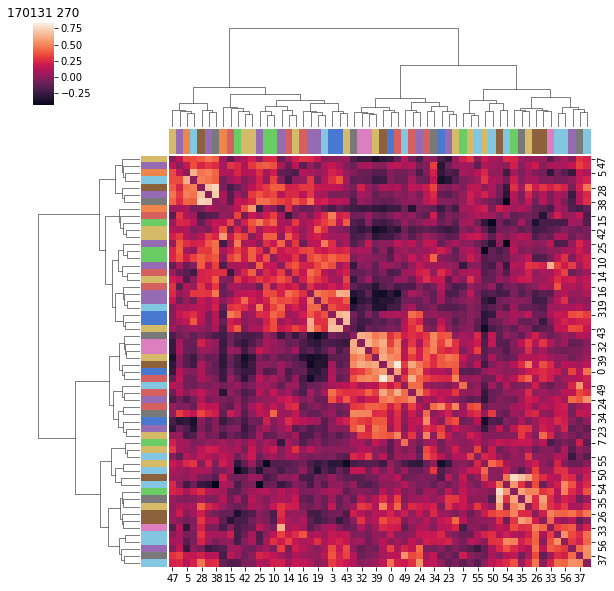

<Figure size 432x288 with 0 Axes>

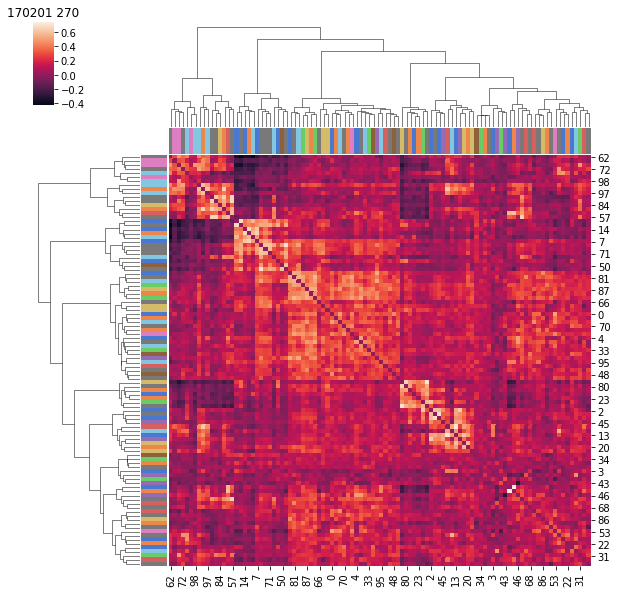

<Figure size 432x288 with 0 Axes>

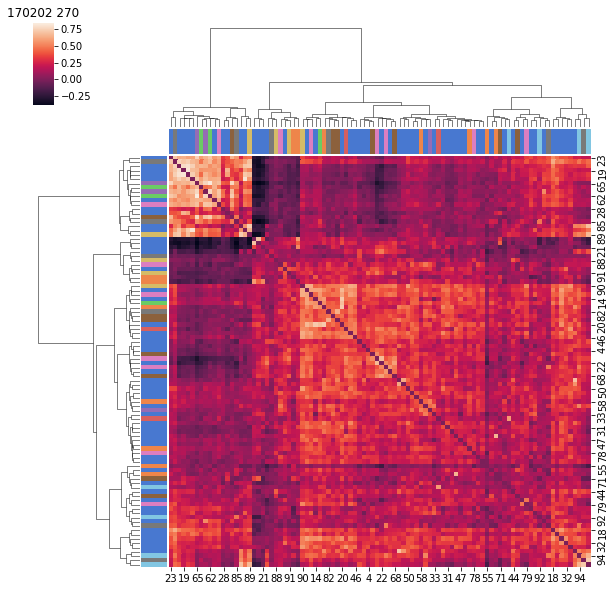

<Figure size 432x288 with 0 Axes>

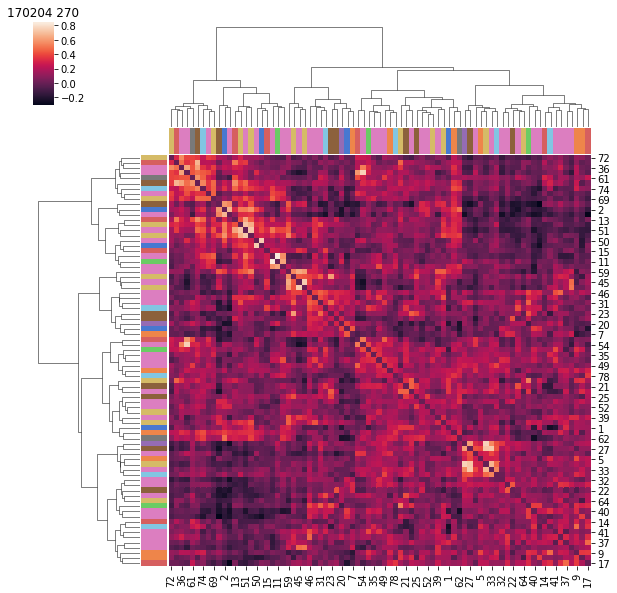

<Figure size 432x288 with 0 Axes>

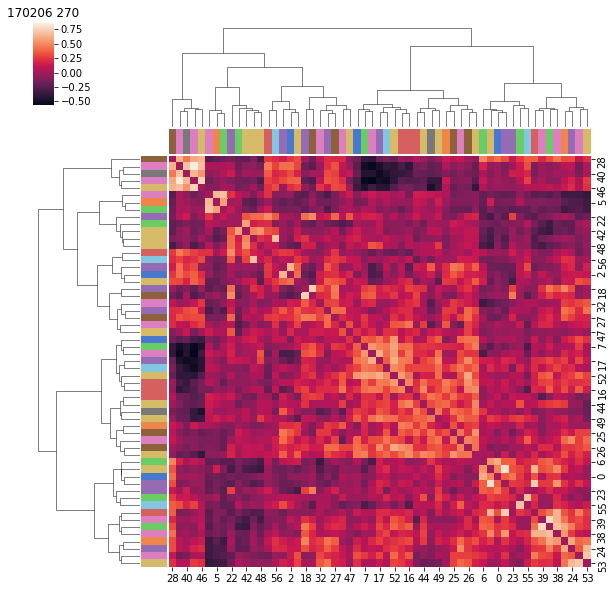

<Figure size 432x288 with 0 Axes>

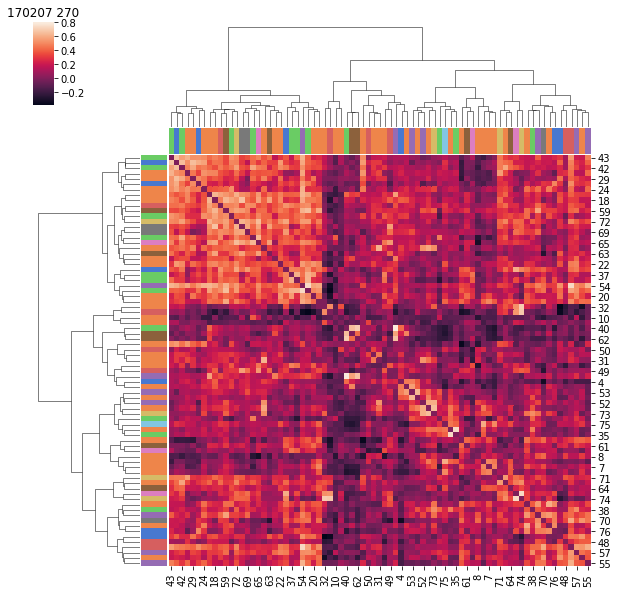

<Figure size 432x288 with 0 Axes>

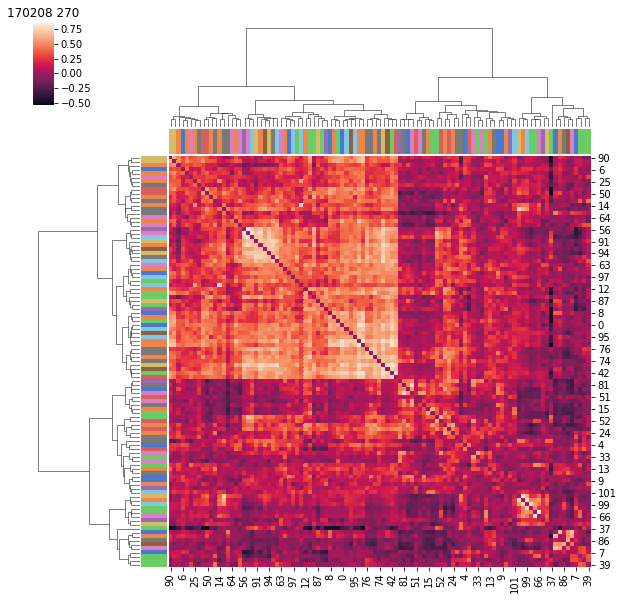

<Figure size 432x288 with 0 Axes>

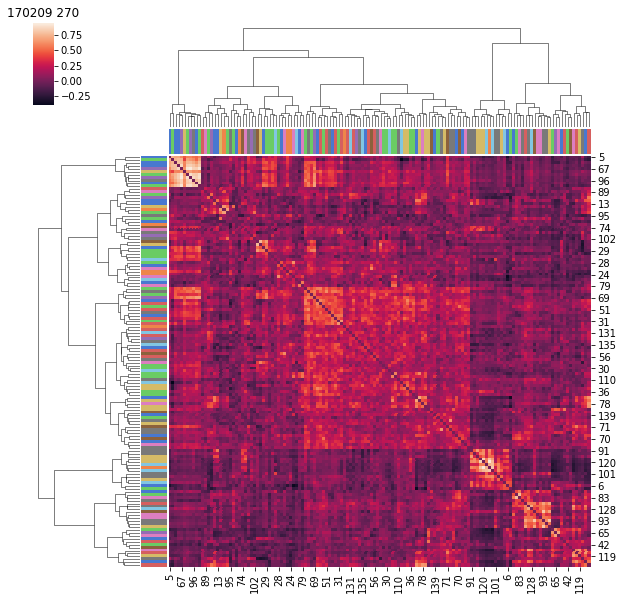

<Figure size 432x288 with 0 Axes>

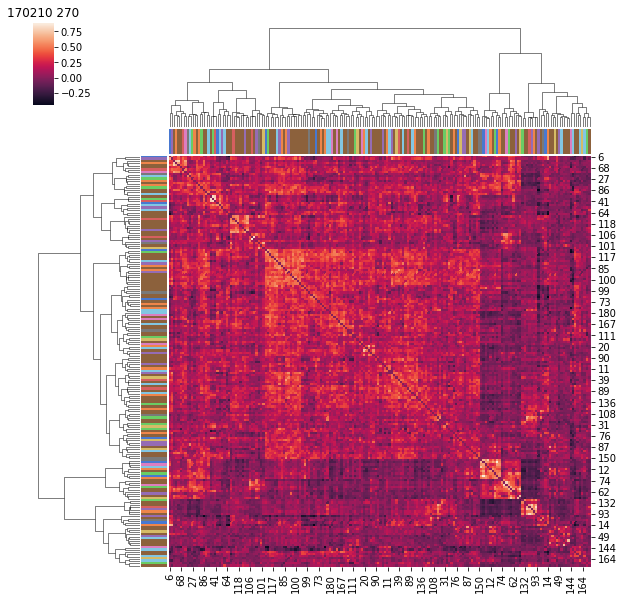

<Figure size 432x288 with 0 Axes>

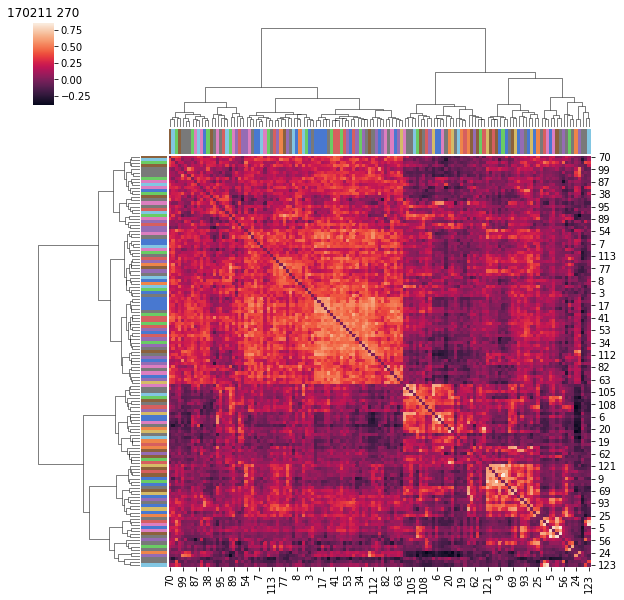

<Figure size 432x288 with 0 Axes>

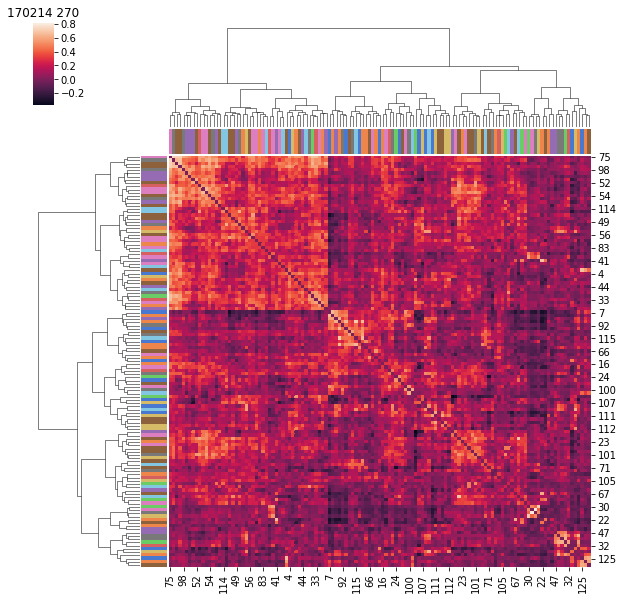

<Figure size 432x288 with 0 Axes>

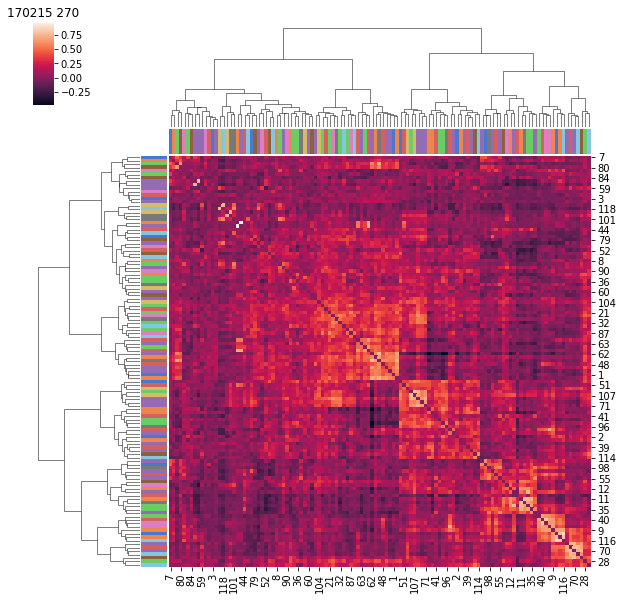

<Figure size 432x288 with 0 Axes>

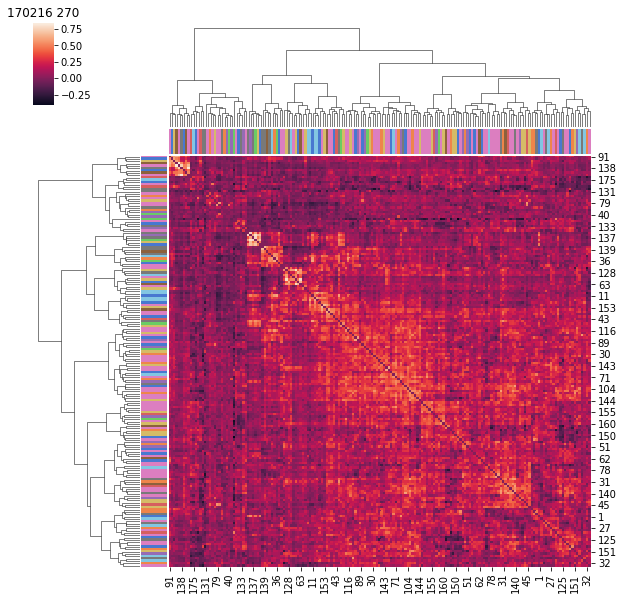

<Figure size 432x288 with 0 Axes>

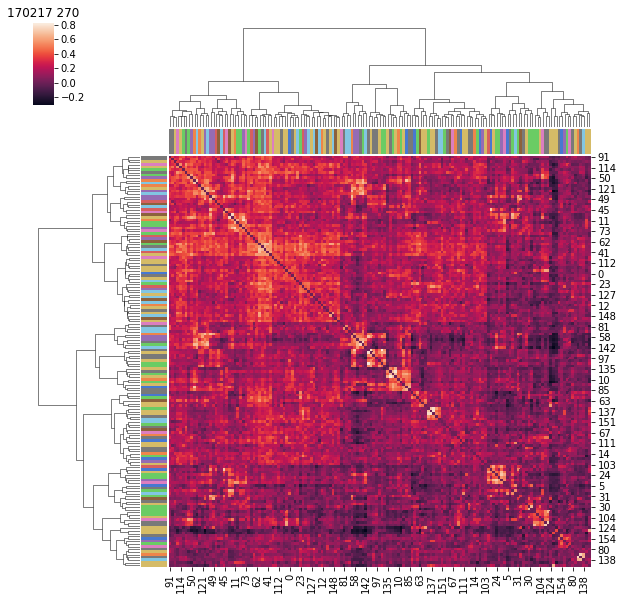

<Figure size 432x288 with 0 Axes>

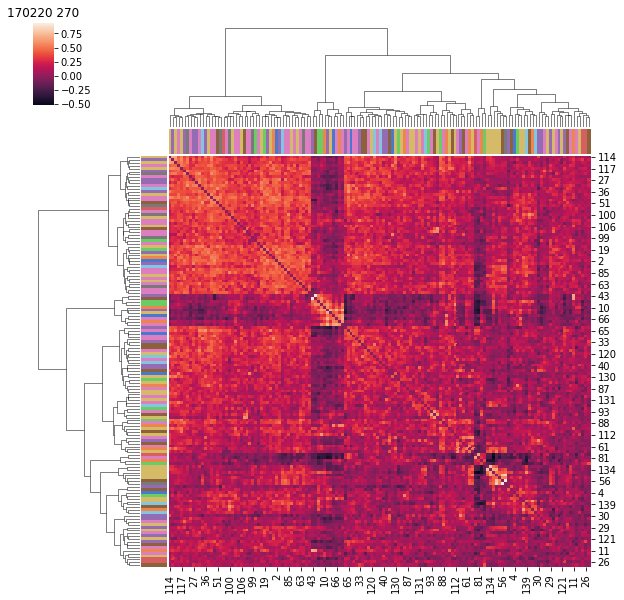

<Figure size 432x288 with 0 Axes>

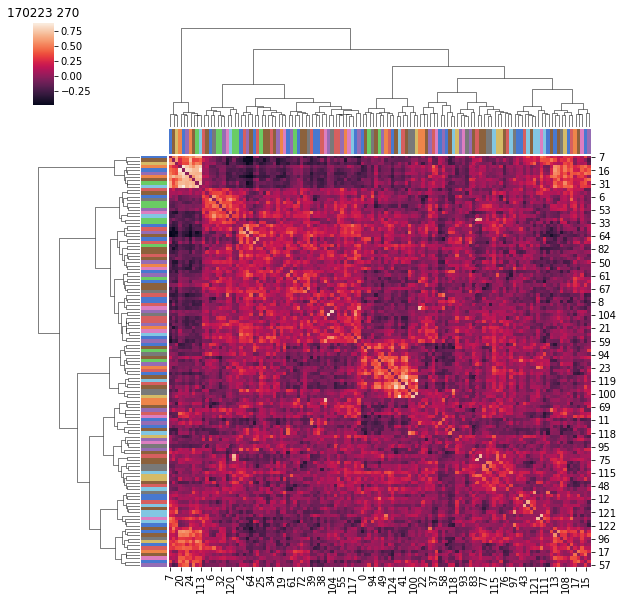

<Figure size 432x288 with 0 Axes>

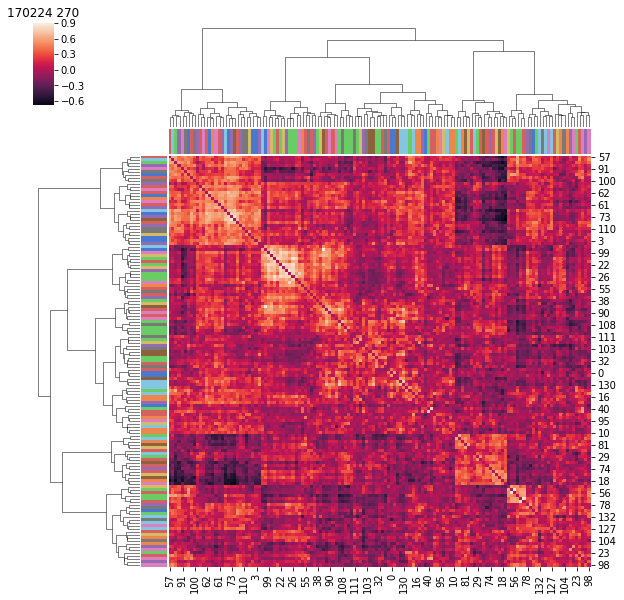

<Figure size 432x288 with 0 Axes>

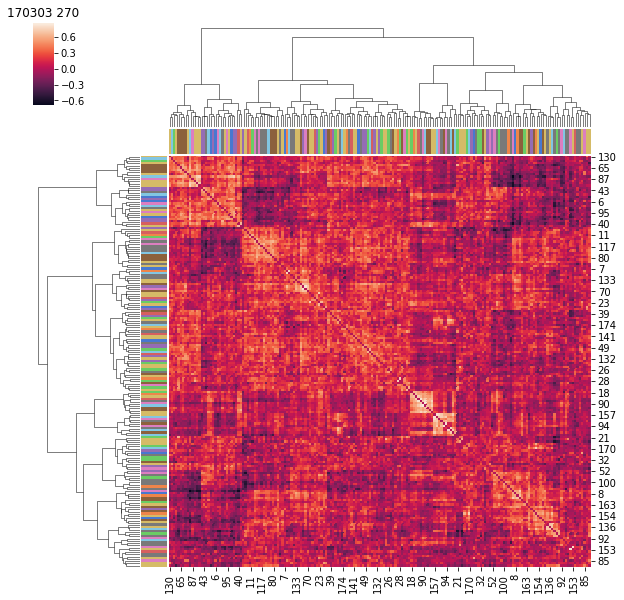

<Figure size 432x288 with 0 Axes>

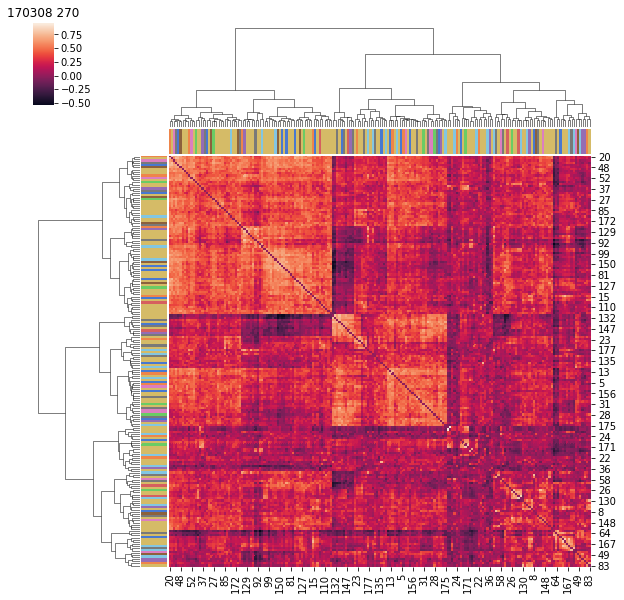

<Figure size 432x288 with 0 Axes>

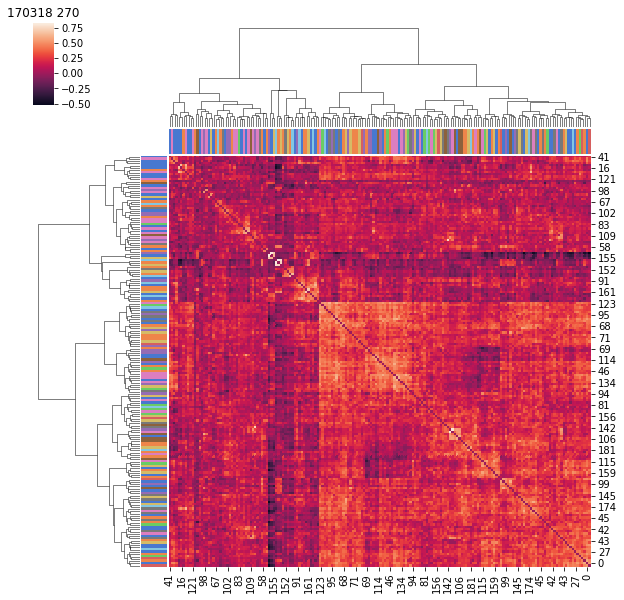

<Figure size 432x288 with 0 Axes>

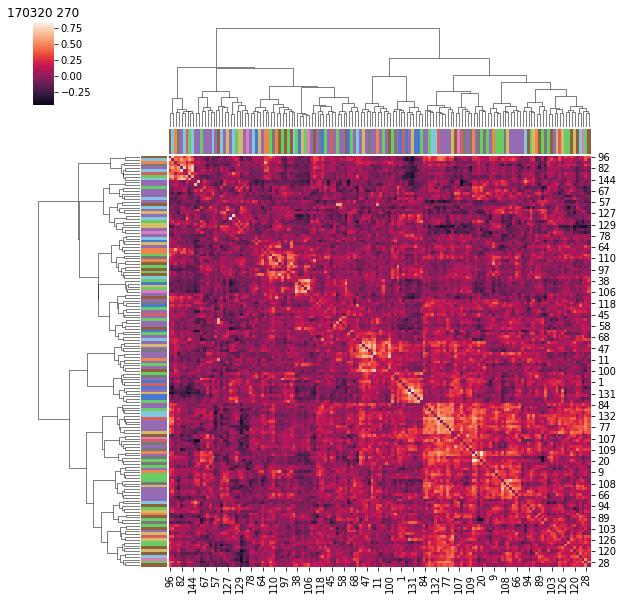

<Figure size 432x288 with 0 Axes>

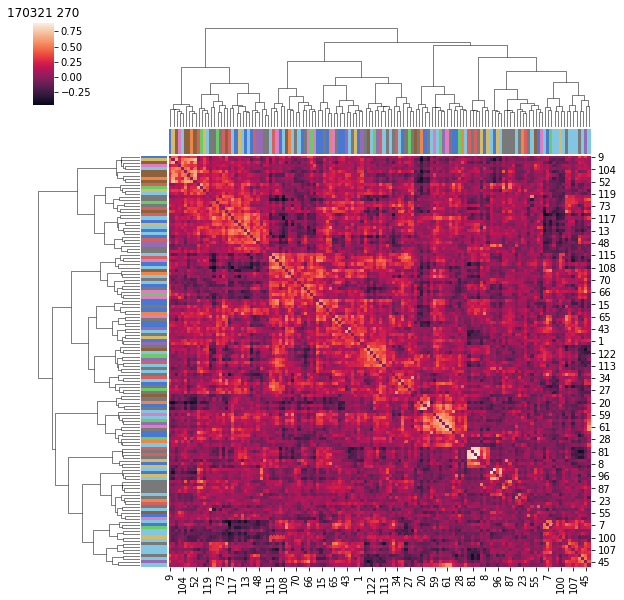

<Figure size 432x288 with 0 Axes>

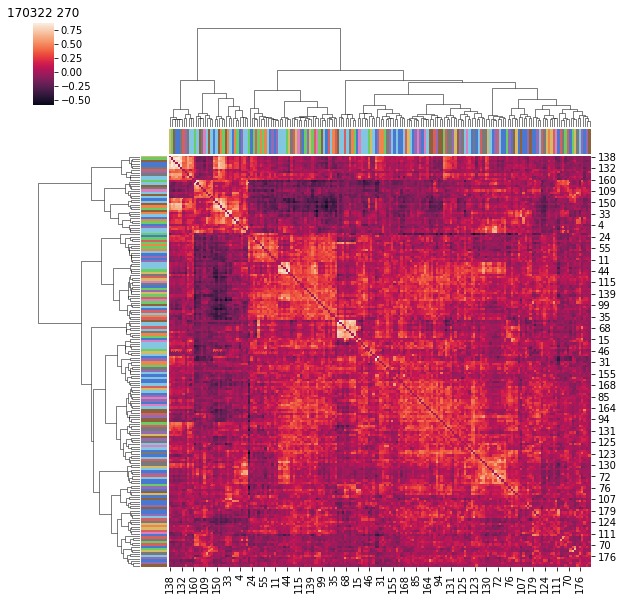

<Figure size 432x288 with 0 Axes>

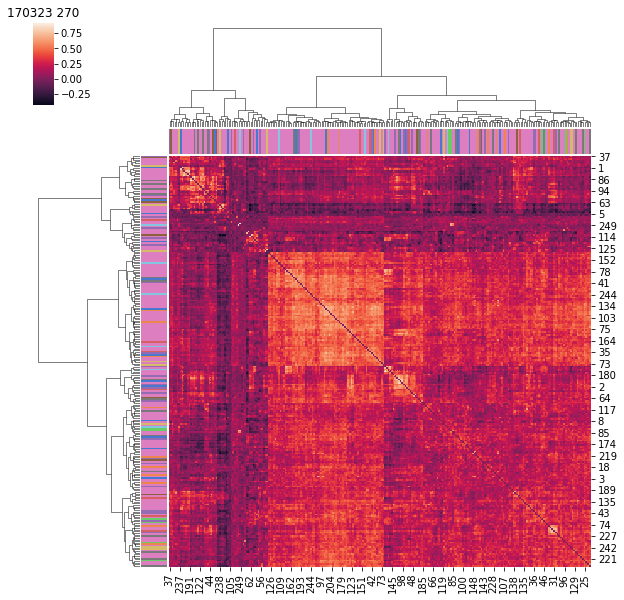

<Figure size 432x288 with 0 Axes>

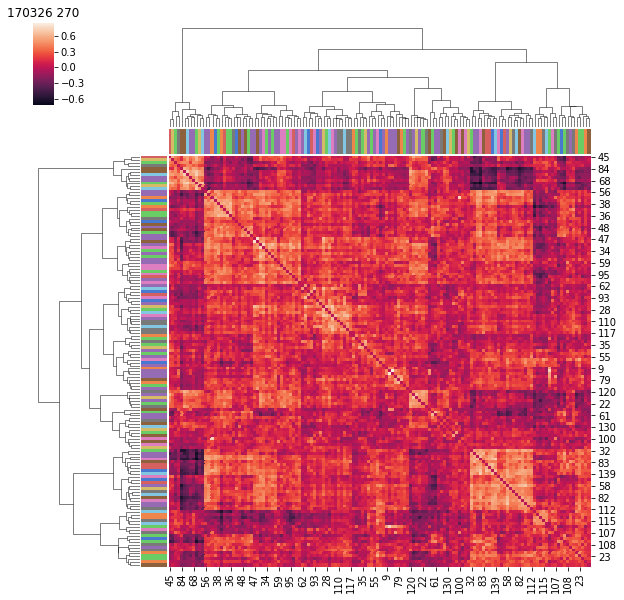

<Figure size 432x288 with 0 Axes>

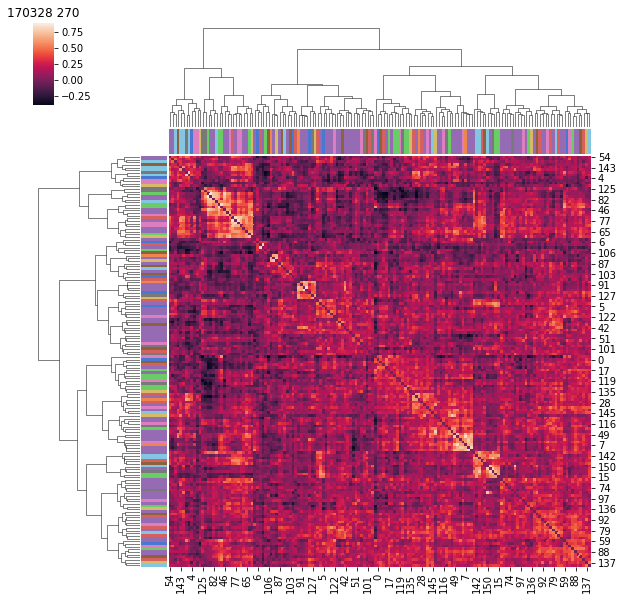

<Figure size 432x288 with 0 Axes>

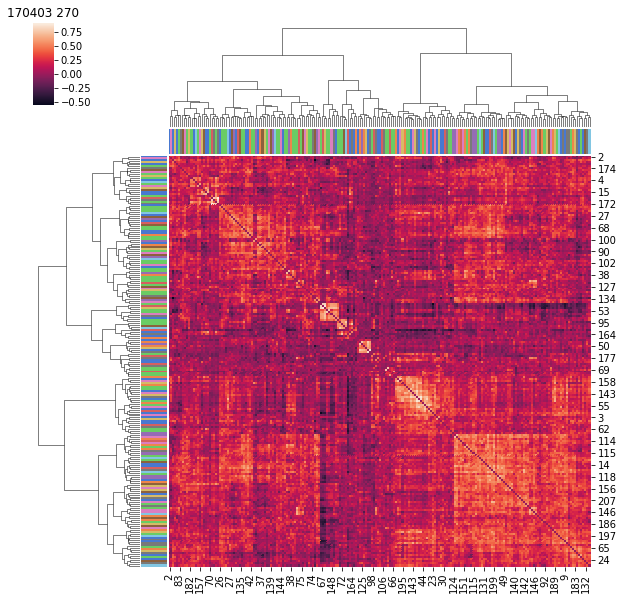

<Figure size 432x288 with 0 Axes>

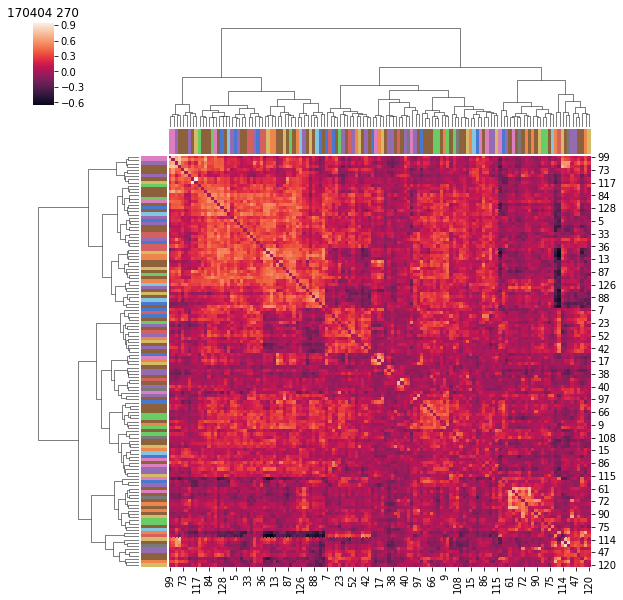

In [122]:
# looking at factors compared to all pairwise cells noise corrlations 
cmap = sns.color_palette('muted', match_rank)
cs = '270'
r = 10
for c, res in enumerate(nz_daily):
#     print(res[10])
    if np.sum(np.isnan(res[r][cs]).flatten()) > 0:
        continue
    color_vec = [cmap[int(k)] for k in clus_daily[c]]
    plt.figure()
    sns.clustermap(res[r][cs], row_cluster=True, col_cluster=True, method='ward', row_colors=color_vec, col_colors=color_vec)
    plt.title(str(days[c].date) + ' ' + cs)

In [ ]:
res[10]

print(k)

In [ ]:
days = flow.DateSorter.frommeta(mice=['OA27'], tags=tags)
for day1 in days:
    
    # get cell_ids
    d1_ids = flow.xday._read_crossday_ids(day1.mouse, day1.date)
    d1_ids = np.array([int(s) for s in d1_ids])

    # filter cells based on visual/trial drive across all cs, prevent
    # breaking when only pavs are shown
    if driven:
        good_ids = cas.tca._group_drive_ids(days, drive_css, drive_threshold)
        d1_ids_bool = np.isin(d1_ids, good_ids)
        d1_sorter = np.argsort(d1_ids[d1_ids_bool])
    else:
        d1_ids_bool = np.ones(np.shape(d1_ids)) > 0
        d1_sorter = np.argsort(d1_ids[d1_ids_bool])
    ids = d1_ids[d1_ids_bool][d1_sorter]
    
    for cs in ['0', '135', '270']:
        test = pool.calc.correlations.noise(day1, cs)
        if np.sum(np.isnan(test.flatten())) > 0:
            continue
        plt.figure()
        sns.clustermap(test[d1_ids_bool][:, d1_ids_bool], method='average')
        plt.title(str(days[0].date))
    break
